In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
# load cleaned dataset
cleaned_movies = pd.read_csv("cleaned_movies.csv")

# Create dummy variables for genres
cleaned_movies['is_romance'] = (cleaned_movies['genre'] == 'Romance').astype(int)
cleaned_movies['is_action'] = (cleaned_movies['genre'] == 'Action').astype(int)

# Define features and target
X = cleaned_movies[['is_romance', 'is_action', 'rating']]  # Features
y = cleaned_movies['gross_earn']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Define Lasso model
lasso = Lasso(max_iter=10000)

# Define grid of alpha values (regularization strength)
alpha_grid = {'alpha': np.logspace(-3, 1, 50)}  # 50 values between 0.001 and 10

# Grid search with cross-validation
grid_search = GridSearchCV(lasso, param_grid=alpha_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_lasso = grid_search.best_estimator_

# Display the best alpha
print(f"Best alpha: {grid_search.best_params_['alpha']}")


Best alpha: 0.001


In [9]:
# Predict on the test set
y_pred = best_lasso.predict(X_test_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 57.65715251719846
R²: 0.005580602461421336


In [10]:
# Create a DataFrame to display coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso.coef_
})

# Sort by absolute coefficient value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

print(coefficients[['Feature', 'Coefficient']])


      Feature  Coefficient
2      rating     5.123524
1   is_action    -0.764577
0  is_romance     0.000000


In [11]:
#use shap to visual genre importance
import shap

# SHAP explainer for linear models
explainer = shap.Explainer(best_lasso, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)


c:\Users\bekah\miniconda3\envs\cs110\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


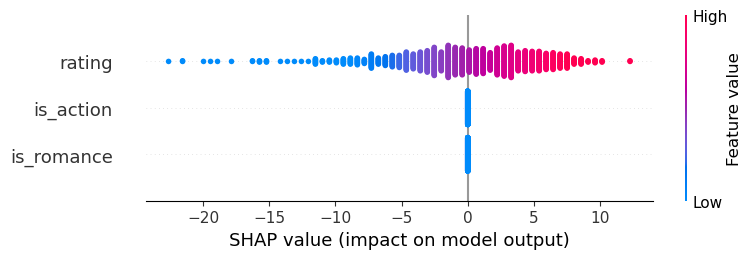

In [12]:
# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


-Axis (Features)
The features are listed on the y-axis:

rating: Likely the movie's rating (e.g., on IMDb or similar).
is_action: A binary feature indicating whether the movie belongs to the action genre.
is_romance: A binary feature indicating whether the movie belongs to the romance genre.
The order reflects their overall importance in the model, with the most influential feature (rating) at the top.
X-Axis (SHAP Value)
The x-axis shows the SHAP values, representing the impact of each feature on the model's predictions:

Positive SHAP Values: Increase the predicted outcome (e.g., higher success).
Negative SHAP Values: Decrease the predicted outcome (e.g., lower success).

Color (Feature Value)
The color gradient indicates the magnitude of the feature's value:

Blue: Low feature value.
Red: High feature value.
Feature-Specific Observations
rating
Higher ratings (red dots on the right) strongly increase the movie's success.
Lower ratings (blue dots on the left) reduce success significantly.
is_action
Being an action movie (is_action = 1) slightly increases success (red points near positive SHAP values).
Non-action movies (is_action = 0) cluster near zero SHAP values, indicating minimal impact on predictions.
is_romance
The impact of romance movies (is_romance = 1) appears split. For some cases, romance movies slightly increase success (red points), but in many, it decreases success (blue points with negative SHAP values).
Non-romance movies (is_romance = 0) generally center around zero SHAP values.


Key Takeaways
Rating is the most critical factor in determining movie success, with higher ratings strongly boosting the outcome.
Action movies seem to slightly enhance success, but their impact is weaker than ratings.
Romance movies have a mixed effect on success. In some cases, they help, but in others, they seem to hinder predictions, depending on the broader context (e.g., other features).

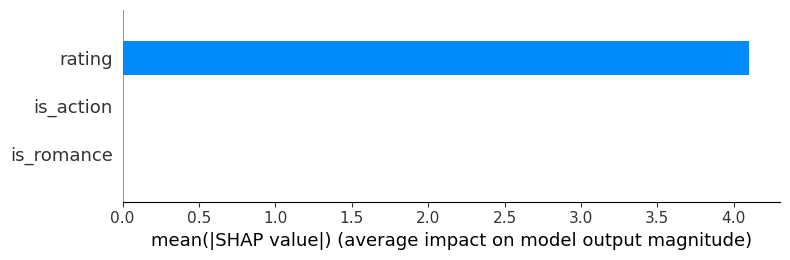

In [13]:
# Bar plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


In [2]:
# Select an observation from the test set
#sample_idx = 0  # Choose the index of the observation
#shap.force_plot(
    #explainer.expected_value, 
    #shap_values[sample_idx].values, 
    #X_test.iloc[sample_idx], 
    #feature_names=X.columns
#)

In [3]:
# Dependence plot for is_romance
#shap.dependence_plot("is_romance", shap_values.values, X_test)

# Dependence plot for is_action
#shap.dependence_plot("is_action", shap_values.values, X_test)


In [1]:
# Interaction plot between 'is_romance' and 'budget'
#shap.dependence_plot(("is_romance", "gross_earn"), shap_values.values, X_test)
